In [2]:
import os
import parse
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext1"

dev_full = os.path.join(datadir, "dev_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
test_full = os.path.join(datadir, "test_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
train_full = os.path.join(datadir, "train_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
devtest_full = os.path.join(datadir, "devtest_onlykeep_False_onlyprimary_True_dedup_False.fasttext")

dev_dd = os.path.join(datadir, "dev_onlykeep_False_onlyprimary_True_dedup_True.fasttext")
test_dd = os.path.join(datadir, "test_onlykeep_False_onlyprimary_True_dedup_True.fasttext")
train_dd = os.path.join(datadir, "train_onlykeep_False_onlyprimary_True_dedup_True.fasttext")
devtest_dd = os.path.join(datadir, "devtest_onlykeep_False_onlyprimary_True_dedup_True.fasttext")


train_labels = ['__label__Legal/Regulation',
 '__label__Opinionated_News',
 '__label__News/Reporting',
 '__label__Forum',
 '__label__Correspondence',
 '__label__Invitation',
 '__label__Instruction',
 '__label__Recipe',
 '__label__Opinion/Argumentation',
 '__label__Promotion_of_Services',
 '__label__Promotion',
 '__label__List_of_Summaries/Excerpts',
 '__label__Promotion_of_a_Product',
 '__label__Call',
 '__label__Review',
 '__label__Other',
 '__label__Information/Explanation',
 '__label__Interview',
 '__label__Prose',
 '__label__Research_Article',
 '__label__Announcement']

STR_TO_NUM = {s: i for i, s in enumerate(train_labels)}
NUM_TO_STR = {i: s for i, s in enumerate(train_labels)}


def parse_fasttext_file(path: str, encode=True):
    """Reads fasttext formatted file and returns dataframe."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            pass
            #print("error parsing line ", line)
    if encode:
        labels = [STR_TO_NUM[i] for i in labels]
    return pd.DataFrame(data={"text": texts, "labels": labels})

for filename in [devtest_dd, devtest_full, train_dd, train_dd]:
    try:
        _ = parse_fasttext_file(filename)
    except Exception as e:
        raise e



def train_and_evaluate(NUM_EPOCHS, SEQ_LENGTH, dedup=False):
    from simpletransformers.classification import ClassificationModel
    model_args = {
        "num_train_epochs": NUM_EPOCHS,
        "learning_rate": 1e-5,
        "overwrite_output_dir": True,
        "train_batch_size": 32,
        "no_save": True,
        "no_cache": True,
        "overwrite_output_dir": True,
        "save_steps": -1,
        "max_seq_length": SEQ_LENGTH
    }

    model = ClassificationModel(
        "camembert", "EMBEDDIA/sloberta",
        num_labels = 21,
        use_cuda = True,
        args = model_args
    )

    if dedup:
        train_df = parse_fasttext_file(train_dd)
        test_df = parse_fasttext_file(devtest_dd)
    else:
        train_df = parse_fasttext_file(train_full)
        test_df = parse_fasttext_file(devtest_full)
    model.train_model(train_df)
    
    y_true_enc = test_df.labels
    y_pred_enc = model.predict(test_df.text.tolist())[0]

    y_true = [NUM_TO_STR[i] for i in y_true_enc]
    y_pred = [NUM_TO_STR[i] for i in y_pred_enc]

    microF1 = f1_score(y_true, y_pred, labels=train_labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=train_labels, average ="macro")

    return microF1, macroF1


# results = [{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 'dedup': False}]
# results = [{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 'dedup': False}, {'seq_length': 512, 'epochs': 50, 'microF1': 0.6404494382022472, 'macroF1': 0.6002096680066665, 'dedup': False}, {'seq_length': 256, 'epochs': 70, 'microF1': 0.651685393258427, 'macroF1': 0.5961122297970485, 'dedup': False}, {'seq_length': 512, 'epochs': 70, 'microF1': 0.6797752808988764, 'macroF1': 0.6450310329192316, 'dedup': False}, {'seq_length': 256, 'epochs': 5, 'microF1': 0.6035502958579881, 'macroF1': 0.32769165856250004, 'dedup': True}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.6153846153846154, 'macroF1': 0.3090550794632427, 'dedup': True}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6686390532544378, 'macroF1': 0.4167655823609181, 'dedup': True}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6627218934911243, 'macroF1': 0.4610292529745417, 'dedup': True}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6568047337278107, 'macroF1': 0.5062635385948797, 'dedup': True}]
results = [{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 'dedup': False}, {'seq_length': 512, 'epochs': 50, 'microF1': 0.6404494382022472, 'macroF1': 0.6002096680066665, 'dedup': False}, {'seq_length': 256, 'epochs': 70, 'microF1': 0.651685393258427, 'macroF1': 0.5961122297970485, 'dedup': False}, {'seq_length': 512, 'epochs': 70, 'microF1': 0.6797752808988764, 'macroF1': 0.6450310329192316, 'dedup': False}, {'seq_length': 256, 'epochs': 5, 'microF1': 0.6035502958579881, 'macroF1': 0.32769165856250004, 'dedup': True}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.6153846153846154, 'macroF1': 0.3090550794632427, 'dedup': True}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6686390532544378, 'macroF1': 0.4167655823609181, 'dedup': True}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6627218934911243, 'macroF1': 0.4610292529745417, 'dedup': True}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6568047337278107, 'macroF1': 0.5062635385948797, 'dedup': True}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.6804733727810651, 'macroF1': 0.5108756978635162, 'dedup': True}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.6627218934911243, 'macroF1': 0.5389396704727715, 'dedup': True}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.7041420118343196, 'macroF1': 0.570274358963473, 'dedup': True}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6331360946745562, 'macroF1': 0.4514622560647306, 'dedup': True}, {'seq_length': 512, 'epochs': 50, 'microF1': 0.6982248520710059, 'macroF1': 0.554488686277034, 'dedup': True}, {'seq_length': 256, 'epochs': 70, 'microF1': 0.6568047337278107, 'macroF1': 0.5664543865406367, 'dedup': True}, {'seq_length': 512, 'epochs': 70, 'microF1': 0.6804733727810651, 'macroF1': 0.5311580704024008, 'dedup': True}]
for dedup in [False, True]:
    for n in [5, 10, 20, 30, 50, 70]:
        for s in [256, 512]:
            if len([i for i in results if i["seq_length"]==s and i["epochs"]==n and i["dedup"]==dedup]) != 0:
                continue  
            micro, macro = train_and_evaluate(n, s, dedup=dedup)
            results.append({
                "seq_length": s,
                "epochs": n,
                "microF1": micro,
                "macroF1": macro,
                "dedup": dedup
            })
            print(results)
            import gc
            gc.collect()

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'

/home/peterr/anaconda3/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:941: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(



[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForS


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.bias'


[{'seq_length': 256, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.2783113155293606, 'dedup': False}, {'seq_length': 512, 'epochs': 5, 'microF1': 0.5674157303370787, 'macroF1': 0.288623344643111, 'dedup': False}, {'seq_length': 256, 'epochs': 10, 'microF1': 0.6235955056179775, 'macroF1': 0.37425652339024196, 'dedup': False}, {'seq_length': 512, 'epochs': 10, 'microF1': 0.6179775280898876, 'macroF1': 0.38527240875066954, 'dedup': False}, {'seq_length': 256, 'epochs': 20, 'microF1': 0.6404494382022472, 'macroF1': 0.5059550790863706, 'dedup': False}, {'seq_length': 512, 'epochs': 20, 'microF1': 0.651685393258427, 'macroF1': 0.6187045443593892, 'dedup': False}, {'seq_length': 256, 'epochs': 30, 'microF1': 0.5955056179775281, 'macroF1': 0.4938982767131578, 'dedup': False}, {'seq_length': 512, 'epochs': 30, 'microF1': 0.6685393258426966, 'macroF1': 0.6340832307649885, 'dedup': False}, {'seq_length': 256, 'epochs': 50, 'microF1': 0.6179775280898876, 'macroF1': 0.5418552167704898, 

In [3]:
results

[{'seq_length': 256,
  'epochs': 5,
  'microF1': 0.5674157303370787,
  'macroF1': 0.2783113155293606,
  'dedup': False},
 {'seq_length': 512,
  'epochs': 5,
  'microF1': 0.5674157303370787,
  'macroF1': 0.288623344643111,
  'dedup': False},
 {'seq_length': 256,
  'epochs': 10,
  'microF1': 0.6235955056179775,
  'macroF1': 0.37425652339024196,
  'dedup': False},
 {'seq_length': 512,
  'epochs': 10,
  'microF1': 0.6179775280898876,
  'macroF1': 0.38527240875066954,
  'dedup': False},
 {'seq_length': 256,
  'epochs': 20,
  'microF1': 0.6404494382022472,
  'macroF1': 0.5059550790863706,
  'dedup': False},
 {'seq_length': 512,
  'epochs': 20,
  'microF1': 0.651685393258427,
  'macroF1': 0.6187045443593892,
  'dedup': False},
 {'seq_length': 256,
  'epochs': 30,
  'microF1': 0.5955056179775281,
  'macroF1': 0.4938982767131578,
  'dedup': False},
 {'seq_length': 512,
  'epochs': 30,
  'microF1': 0.6685393258426966,
  'macroF1': 0.6340832307649885,
  'dedup': False},
 {'seq_length': 256,
  'ep

In [4]:
!pwd

/home/peterr/macocu/task5_webgenres


In [5]:
import json

with open("hyperparameter_data.json", "w") as f:
    json.dump(results, f)

In [6]:
import matplotlib.pyplot as plt 
plt.style.use(["science", "no-latex"])

import pandas as pd


In [7]:
df = pd.DataFrame(data=results)
df.head()

,seq_length,epochs,microF1,macroF1,dedup
0,256,5,0.567416,0.278311,False
1,512,5,0.567416,0.288623,False
2,256,10,0.623596,0.374257,False
3,512,10,0.617978,0.385272,False
4,256,20,0.640449,0.505955,False


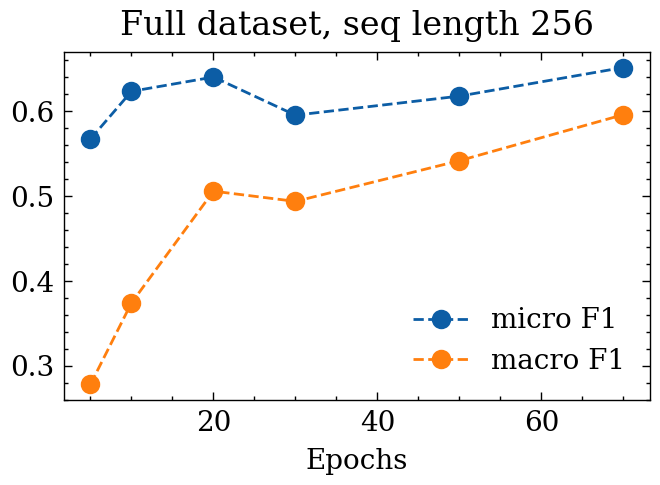

In [16]:
filter1 = df.seq_length == 256
filter2 = df.dedup == False

subset = df[filter1 & filter2]


plt.figure(dpi=200)
plt.plot(subset.epochs, subset.microF1, "o--", label="micro F1")
plt.plot(subset.epochs, subset.macroF1, "o--", label="macro F1", color="tab:orange")
plt.xlabel("Epochs")
plt.legend()

plt.title("Full dataset, seq length 256")
plt.tight_layout()

plt.savefig("images/hyperparams_1.png")
plt.show()

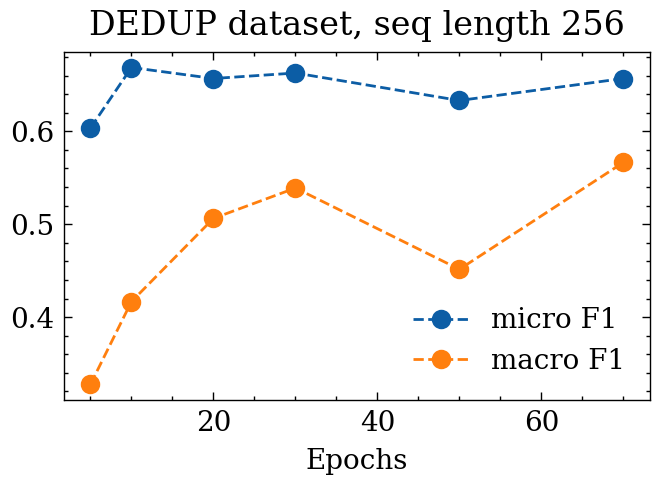

In [18]:
filter1 = df.seq_length == 256
filter2 = df.dedup == True

subset = df[filter1 & filter2]


plt.figure(dpi=200)
plt.plot(subset.epochs, subset.microF1, "o--", label="micro F1")
plt.plot(subset.epochs, subset.macroF1, "o--", label="macro F1", color="tab:orange")
plt.xlabel("Epochs")
plt.legend()

plt.title("DEDUP dataset, seq length 256")
plt.tight_layout()

plt.savefig("images/hyperparams_2.png")
plt.show()

Comparison between seq lengths:

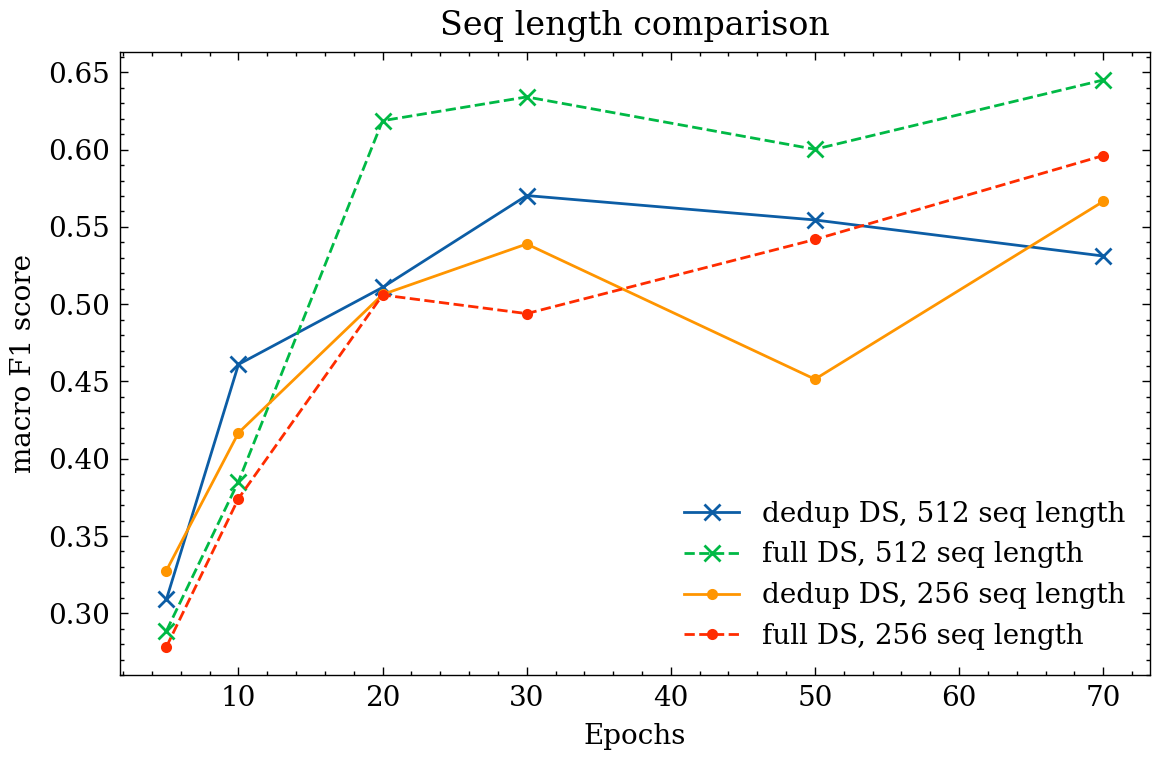

In [26]:


plt.figure(dpi=200, figsize=(6,4))

for s in [512, 256]:
    for dedup in [True, False]:
        condition1 = df.seq_length == s
        condition2 = df.dedup == dedup
        sub = df[condition1 & condition2]
        if dedup:
            lst = "-"
        else:
            lst = "--"
        if s == 512:
            m = "x"
        else:
            m = "."
        plt.plot(sub.epochs, sub.macroF1, label=f"{'full' if not dedup else 'dedup'} DS, {s} seq length",
                linestyle=lst, 
                marker=m
                )       
plt.ylabel("macro F1 score")
plt.xlabel("Epochs")
plt.legend()

plt.title("Seq length comparison")
plt.tight_layout()

plt.savefig("images/hyperparams_3.png")
plt.show()

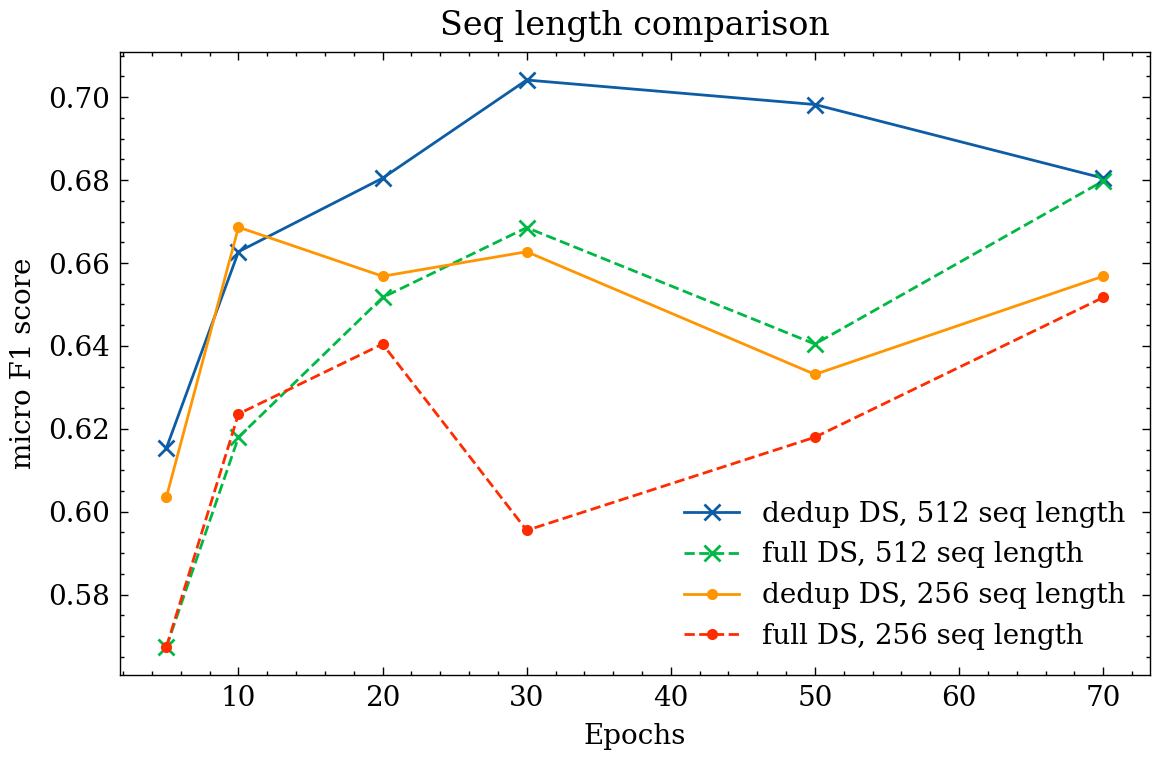

In [27]:


plt.figure(dpi=200, figsize=(6,4))

for s in [512, 256]:
    for dedup in [True, False]:
        condition1 = df.seq_length == s
        condition2 = df.dedup == dedup
        sub = df[condition1 & condition2]
        if dedup:
            lst = "-"
        else:
            lst = "--"
        if s == 512:
            m = "x"
        else:
            m = "."
        plt.plot(sub.epochs, sub.microF1, label=f"{'full' if not dedup else 'dedup'} DS, {s} seq length",
                linestyle=lst, 
                marker=m
                )       
plt.ylabel("micro F1 score")
plt.xlabel("Epochs")
plt.legend()

plt.title("Seq length comparison")
plt.tight_layout()

plt.savefig("images/hyperparams_4.png")
plt.show()